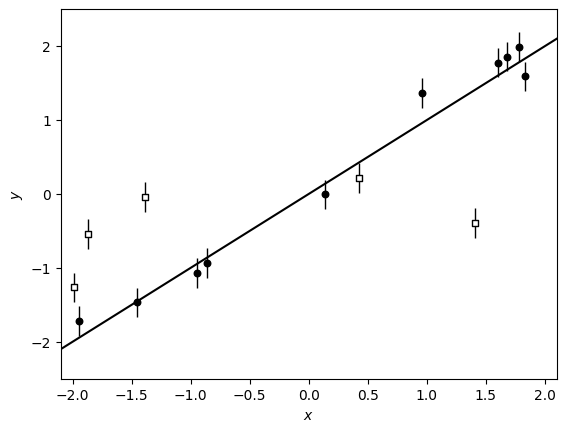

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)


def plot_data():
    plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", edgecolor="k", zorder=1000)
    plt.scatter(
        x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000, label="data"
    )
    plt.plot(x0, y0, color="k", lw=1.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.1, 2.1)


plot_data()

In [11]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

numpyro.set_host_device_count(2)


def linear_model(x, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0, 1))

    # Transformed parameters (and other things!) can be tracked during sampling using
    # "deterministics" as follows:
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

In [ ]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(linear_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), x, yerr, y=y)

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: total: 6.75 s
Wall time: 4.76 s


Running chain 0:   0%|          | 0/4000 [00:04<?, ?it/s]

In [14]:
import arviz as az

inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.123,0.052,0.020,0.216,0.001,0.001,3952.0,2901.0,1.0
b_perp,0.098,0.041,0.021,0.176,0.001,0.000,3951.0,2845.0,1.0
m,0.757,0.035,0.692,0.825,0.001,0.000,3484.0,2466.0,1.0
theta,0.648,0.022,0.606,0.690,0.000,0.000,3484.0,2466.0,1.0


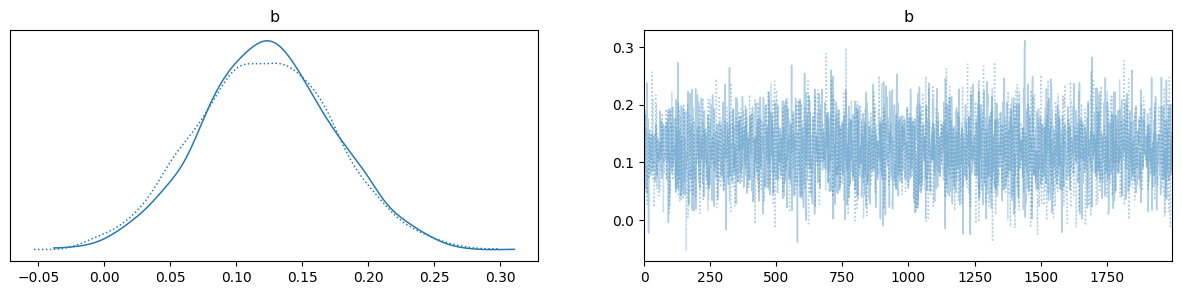

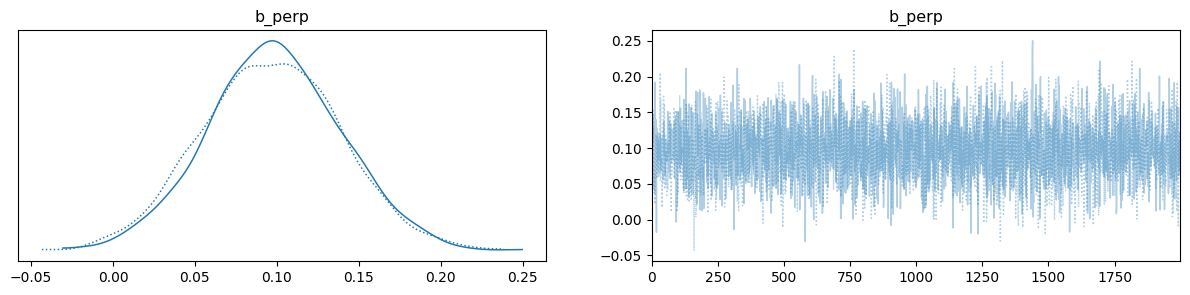

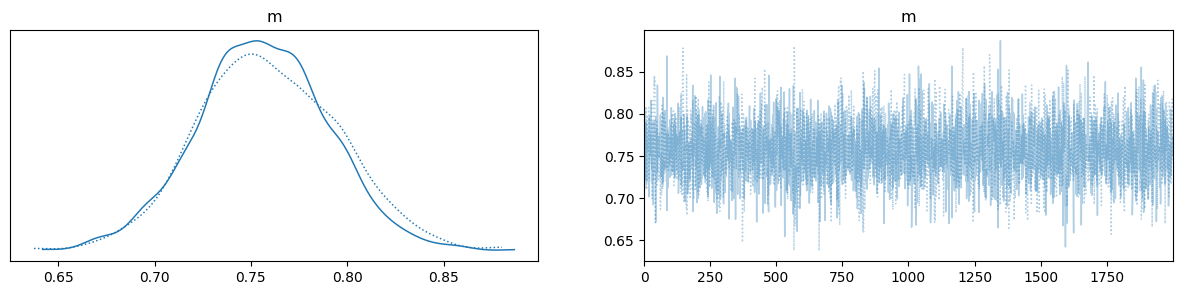

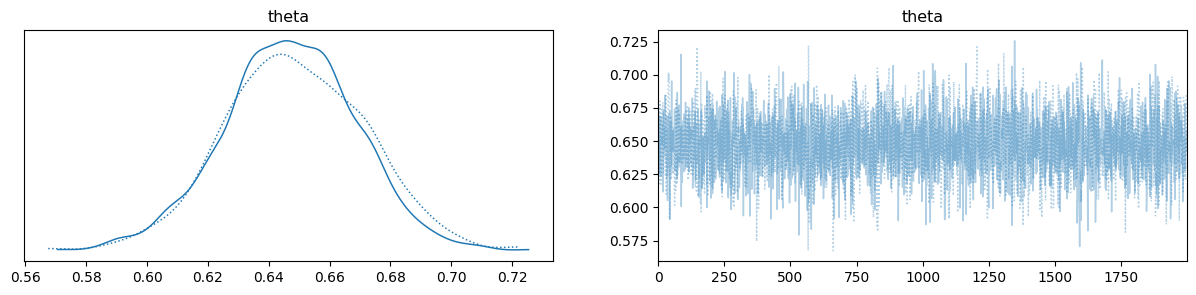

In [15]:
az.plot_trace(inf_data, var_names=['b'], compact=True, figsize=(15, 3));
az.plot_trace(inf_data, var_names=['b_perp'], compact=True, figsize=(15, 3));
az.plot_trace(inf_data, var_names=['m'], compact=True, figsize=(15, 3));
az.plot_trace(inf_data, var_names=['theta'], compact=True, figsize=(15, 3));

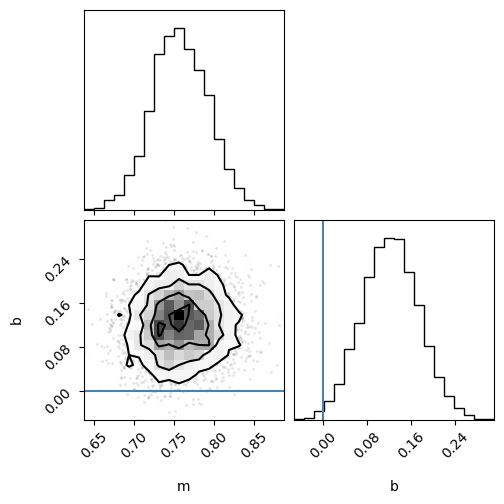

In [16]:
import corner

corner.corner(inf_data, var_names=["m", "b"], truths=true_params);

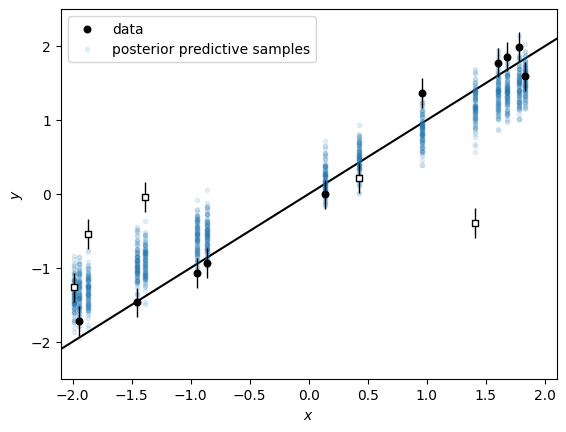

In [17]:
# simulating data that we would expect to see, given our posterior,
# which we can then compare to our observed data.

post_pred_samples = infer.Predictive(linear_model, sampler.get_samples())(
    jax.random.PRNGKey(1), x, yerr
)
post_pred_y = post_pred_samples["y"]

plot_data()
label = "posterior predictive samples"
for n in np.random.default_rng(0).integers(len(post_pred_y), size=100):
    plt.plot(x, post_pred_y[n], ".", color="C0", alpha=0.1, label=label)
    label = None
plt.legend();

In [24]:
from numpyro import distributions as dist
import numpyro_ext
from numpyro_ext import distributions as distx


In [ ]:

from numpyro_ext.distributions import MixtureGeneral


def linear_mixture_model(x, yerr, y=None):
    # Our "foreground" model is identical to the one we used previously: a line
    # parameterized by "theta" and "b_perp". Note that we don't wrap the actual
    # sampling distribution in a `numpyro.sample` here because we're going to
    # use it in the mixture distribution below.
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)

    # Our outlier model is a Gaussian where we're fitting for the zero and
    # standard deviation.
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))

    # We use a `Catagorical` distribution to define the outlier probability. We
    # fit for the parameter `Q` which specifies the probability that any
    # individual point is a member of the foreground model. Therefore, the
    # "prior" outlier probability is `1 - Q`.
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    mix = dist.Categorical(probs=jnp.array([Q, 1.0 - Q]))

    # As with the previous model, the use of a `plate` here is optional, but
    # let's do it anyways.
    with numpyro.plate("data", len(x)):
        # The `numpyro.distributions` module doesn't yet implement a mixture
        # distribution that is flexible enough for our use cases, so we'll use
        # one that I implemented in the `numpyro-ext` package. (This is sort of
        # a lie: the `MixtureSameFamily` distribution in NumPyro _would_ work
        # here, but not in our next example, so bear with me!)
        numpyro.sample("obs", MixtureGeneral(mix, [fg_dist, bg_dist]), obs=y)


# Our inference procedure is identical to the one above.
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: total: 13 s
Wall time: 10.7 s


Running chain 0:   0%|          | 0/4000 [00:10<?, ?it/s]

Running chain 0: 100%|██████████| 4000/4000 [00:12<00:00, 325.13it/s] 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q,0.665,0.127,0.428,0.888,0.002,0.001,3934.0,3068.0,1.0
b,0.053,0.078,-0.098,0.197,0.001,0.001,3064.0,2479.0,1.0
b_perp,0.038,0.055,-0.069,0.140,0.001,0.001,3003.0,2296.0,1.0
bg_mean,-0.417,0.397,-1.187,0.348,0.009,0.006,2220.0,2155.0,1.0
bg_sigma,0.782,0.531,0.023,1.670,0.011,0.007,2214.0,1684.0,1.0
m,1.007,0.056,0.900,1.113,0.001,0.001,2740.0,2793.0,1.0
theta,0.788,0.028,0.733,0.839,0.001,0.000,2740.0,2793.0,1.0


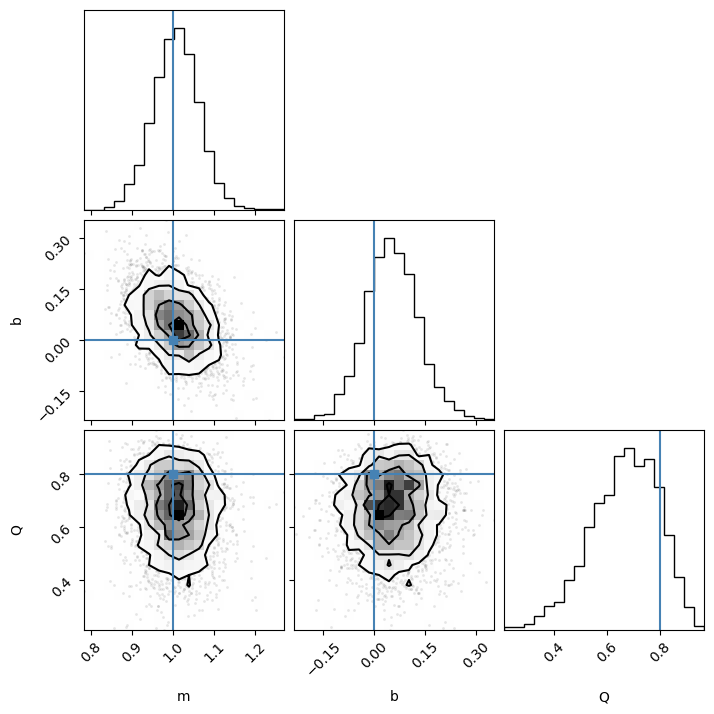

In [26]:
inf_data = az.from_numpyro(sampler)
corner.corner(
    inf_data,
    var_names=["m", "b", "Q"],
    truths={
        "m": true_params[0],
        "b": true_params[1],
        "Q": true_frac,
    },
)
az.summary(inf_data)

In [27]:
def linear_mixture_member_prob_model(x, yerr, y=None):
    # Most of the model is identiacal to the one above...
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    mixture = MixtureGeneral(
        dist.Categorical(probs=jnp.array([Q, 1.0 - Q])), [fg_dist, bg_dist]
    )
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "p", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )


# Our inference procedure is identical to the one above.
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_member_prob_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: total: 11.6 s
Wall time: 8.58 s


Running chain 0:   0%|          | 0/4000 [00:07<?, ?it/s]

Running chain 1: 100%|██████████| 4000/4000 [00:09<00:00, 415.38it/s] 


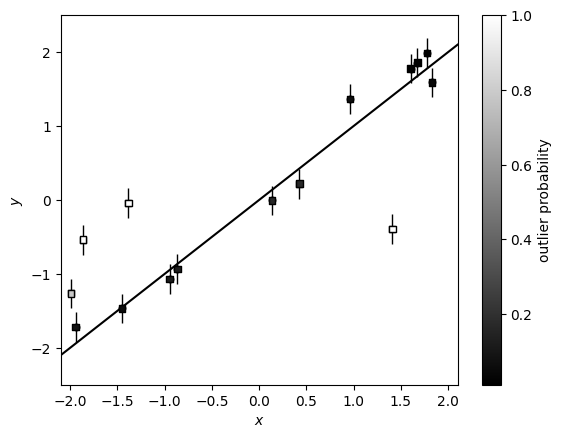

In [28]:
p_fg = jnp.mean(jnp.exp(sampler.get_samples()["p"][..., 0]), axis=0)
plot_data()
plt.scatter(x, y, marker="s", s=22, c=1 - p_fg, edgecolor="k", zorder=1000, cmap="gray")
plt.colorbar(label="outlier probability");